In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
from torch.utils.data.sampler import SubsetRandomSampler
import os
from datetime import datetime
import time
from IPython import display
from tqdm import tqdm

%matplotlib inline

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.set_default_tensor_type(torch.FloatTensor)
# torch.cuda.is_available()

In [2]:
import pandas as pd
from scipy.ndimage import gaussian_filter
from torch.autograd import Variable
from torch.optim import Adam
from nilearn import plotting
import nibabel as nib
import nilearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import  StratifiedKFold

In [3]:
import sys
sys.path.append("..")

# import utils 
from utils.viz_tools import plot_central_cuts
from utils.data import MriSegmentation, MriClassification
from utils.routine import *
from models.cnn_model import *

In [4]:
from typing import Dict, Callable, Tuple, Sequence, Union, Optional

In [5]:
all_data = MriClassification(sample='all', data_type = 'img', ignore_missing= True,
                         image_path= '/gpfs/gpfs0/sbi/data/fcd_classification_bank',
                         targets_path= '../targets/targets_fcd_bank.csv')

  0%|          | 2/1404 [00:00<01:53, 12.31it/s]

Assembling data for:  all  sample.


100%|██████████| 1404/1404 [01:38<00:00, 14.20it/s]


In [6]:
import sys  
sys.path.insert(0, './models')
from AE_model_new import AE, Discriminator, Classificator

In [7]:
DEFAULT_CUTOFF = 0.01, 0.99
STANDARD_RANGE = 0, 100

def _standardize_cutoff(cutoff: np.ndarray) -> np.ndarray:
    """Standardize the cutoff values given in the configuration.

    Computes percentile landmark normalization by default.

    """
    cutoff = np.asarray(cutoff)
    cutoff[0] = max(0., cutoff[0])
    cutoff[1] = min(1., cutoff[1])
    cutoff[0] = np.min([cutoff[0], 0.09])
    cutoff[1] = np.max([cutoff[1], 0.91])
    return cutoff



def _get_average_mapping(percentiles_database: np.ndarray) -> np.ndarray:
    """Map the landmarks of the database to the chosen range.

    Args:
        percentiles_database: Percentiles database over which to perform the
            averaging.
    """
    # Assuming percentiles_database.shape == (num_data_points, num_percentiles)
    pc1 = percentiles_database[:, 0]
    pc2 = percentiles_database[:, -1]
    s1, s2 = STANDARD_RANGE
    slopes = (s2 - s1) / (pc2 - pc1)
    slopes = np.nan_to_num(slopes)
    intercepts = np.mean(s1 - slopes * pc1)
    num_images = len(percentiles_database)
    final_map = slopes.dot(percentiles_database) / num_images + intercepts
    return final_map


def _get_percentiles(percentiles_cutoff: Tuple[float, float]) -> np.ndarray:
    quartiles = np.arange(25, 100, 25).tolist()
    deciles = np.arange(10, 100, 10).tolist()
    all_percentiles = list(percentiles_cutoff) + quartiles + deciles
    percentiles = sorted(set(all_percentiles))
    return np.array(percentiles)

def normalize(
        tensor,
        landmarks,
        mask = None,
        cutoff= None,
        epsilon= 1e-5,
        ):
    cutoff_ = DEFAULT_CUTOFF if cutoff is None else cutoff
    array = tensor.numpy()
    mapping = landmarks

    data = array
    shape = data.shape
    data = data.reshape(-1).astype(np.float32)

    if mask is None:
        mask = np.ones_like(data, np.bool)
    mask = mask.reshape(-1)

    range_to_use = [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12]

    quantiles_cutoff = _standardize_cutoff(cutoff_)
    percentiles_cutoff = 100 * np.array(quantiles_cutoff)
    percentiles = _get_percentiles(percentiles_cutoff)
    percentile_values = np.percentile(data[mask], percentiles)

    # Apply linear histogram standardization
    range_mapping = mapping[range_to_use]
    range_perc = percentile_values[range_to_use]
    diff_mapping = np.diff(range_mapping)
    diff_perc = np.diff(range_perc)

    # Handling the case where two landmarks are the same
    # for a given input image. This usually happens when
    # image background is not removed from the image.
    diff_perc[diff_perc < epsilon] = np.inf

    affine_map = np.zeros([2, len(range_to_use) - 1])

    # Compute slopes of the linear models
    affine_map[0] = diff_mapping / diff_perc

    # Compute intercepts of the linear models
    affine_map[1] = range_mapping[:-1] - affine_map[0] * range_perc[:-1]

    bin_id = np.digitize(data, range_perc[1:-1], right=False)
    lin_img = affine_map[0, bin_id]
    aff_img = affine_map[1, bin_id]
    new_img = lin_img * data + aff_img
    new_img = new_img.reshape(shape)
    new_img = new_img.astype(np.float32)
    new_img = torch.from_numpy(new_img)
    return new_img

def default_collate(batch):
    'batch = list of tuples(X, y, domain)'
    landmarks = np.load('./weights/fcd_train_data_landmarks.npy')
    X = torch.stack([normalize(item[0], landmarks) for item in batch])
    y = torch.LongTensor([item[1] for item in batch])    
    domain = torch.LongTensor([item[2] for item in batch]) 

    return X, y, domain

In [8]:
def train_val_split(dataset, train_idx, test_ratio=0.3, batch_size=2):
    ''' Returns train and validation dataloaders '''
    y = dataset.scan[train_idx].values
    train_indices, val_indices, y_train, y_val = train_test_split(train_idx, y, test_size=test_ratio, stratify=y)
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                            sampler=train_sampler, num_workers=0, drop_last=False,collate_fn=default_collate)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                            sampler=valid_sampler, num_workers=0, drop_last=False, collate_fn=default_collate)
    
    return train_loader, val_loader

In [9]:
holdout_idx = all_data.scan[all_data.scan == 4]

In [10]:
test_data_0 = Subset(all_data, holdout_idx)
test_loader_0 = torch.utils.data.DataLoader(test_data_0, batch_size=1, 
                             num_workers=0, drop_last=False, collate_fn=default_collate)

In [11]:
len(test_loader_0)

30

In [12]:
sample_X, sample_y, sample_domain = iter(test_loader_0).next()

In [13]:
sample_X.shape

torch.Size([1, 1, 192, 192, 192])

In [14]:
def get_answers(loader):
    ans = []
    for (X, y, domain) in loader:
        ans.append(y.item())
    
    return ans

In [15]:
y = get_answers(test_loader_0)

In [16]:
down_block_kwargs = {
    'conv_k': 6,
    'conv_pad': 2,
    'conv_s': 2,
    'maxpool_k': 2,
    'maxpool_s': 2,
    'batch_norm': True,
    'act': 'l_relu' ##'or l_relu'
}
up_block_kwargs = {
    'up': 'upsample',# or 'transpose_conv'
    'scale': 4,
    'scale_mode': 'nearest',
    'conv_k': 3,
    'conv_pad': 1,
    'conv_s': 1,
    'batch_norm': False,
    'act': 'l_relu' ##'or relu'
}
ae_kwargs ={
    'c_in':1,
    'is_skip': False,
    'deapth': 3,
    'c_base': 8,
    'inc_size':2,
    'reduce_size': False,
    'down_block_kwargs': down_block_kwargs,
    'up_block_kwargs': up_block_kwargs,
}
discriminator_kwargs = {
    'c_in': 32,
    'c_out':64,
    'conv_k': 3,
    'conv_s': 1,
    'conv_pad': 0,
    'l_in': 64,
    'l_out': 32,
    'batch_norm': True,
    'act': 'relu',
    'n_domains':18,
    'p_drop': 0.5,
    
}
classificator_kwargs = {
    'c_in': 32,
    'c_out':64,
    'conv_k': 3,
    'conv_s': 1,
    'conv_pad': 0,
    'l_in': 64,
    'l_out': 32,
    'batch_norm': True,
    'act': 'relu',
    'p_drop': 0.5,
    'n_class':2
}
n_domains = 18
encoder = AE(**ae_kwargs).enc
# disc = Discriminator(**discriminator_kwargs)
clf = Classificator(**classificator_kwargs)
model = AE(**ae_kwargs)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder.to(device)
clf.to(device);

In [18]:
encoder.load_state_dict(torch.load('./weights/encoder.pth', map_location='cuda:0'))
clf.load_state_dict(torch.load('./weights/clf.pth', map_location='cuda:0'))

<All keys matched successfully>

In [19]:
# encoder.load_state_dict(torch.load('./results/3/encoder.pth'))
# clf.load_state_dict(torch.load('./results/3/clf.pth'))

In [20]:
encoder.eval()
clf.eval();

In [21]:
device

'cuda'

In [22]:
class Net(nn.Module):
    def __init__(self, enc, clf):
        super(Net, self).__init__()
        self.enc = enc
        self.clf = clf
    
    def forward(self, x):
        x, _ = self.enc(x)
        x = self.clf(x)
        return x

In [23]:
net = Net(encoder, clf)
net.to(device)
net = net.float()
net.eval()
for param in net.parameters():
    param.requires_grad = False

In [24]:
net(sample_X.to(device))

tensor([[-1.0416, -0.0358]], device='cuda:0')

In [25]:
F.softmax(net(sample_X.to(device)))

/trinity/shared/opt/python-3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.2678, 0.7322]], device='cuda:0')

In [26]:
# del clf
# del encoder

In [27]:
# def get_prediction(sample):
#     encoder.eval()
#     clf.eval()
    
#     sample = sample.to(device)
#     x, _ = encoder(sample)
#     x = clf(x)
#     return x

In [28]:
# test_ans = get_prediction(sample_X)

In [29]:
# test_ans

In [30]:
def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    
    for (data, target, _) in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target,out,pred
    accuracy = 100. * correct / len(data_loader.dataset)
    del correct
    return accuracy.item()
    del accuracy
    
def get_loss(net, data_loader):
    net.eval()
    loss = 0 
    for (data, target, _) in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        loss += criterion(out, target).item()*len(data)

        del data, target, out 

    return loss / len(data_loader.dataset)
    del loss
    
def get_prediction(net, data_loader):
    net.eval()
    pred_list = []
    for (data, target, _) in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred_list.append(out.data.max(1)[1].detach().cpu().numpy()) 
        del data, target,out
    return pred_list

In [31]:
torch.manual_seed(1)
np.random.seed(1)
c = 32

In [32]:
pred = np.concatenate(get_prediction(net, test_loader_0), axis=0)

In [33]:
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
print(accuracy_score(y, pred))

1.0


In [35]:
def jittering(img,jit,C,D,H,W) :
    return np.resize(img,(C,D+jit,H+jit,W+jit))

def upsample(mask, img_size):
    x = F.interpolate(mask, size=img_size, mode='trilinear', align_corners=False)
    return x
    del x
    
def np_to_torch(X,device,img_size,requires_grad = False):
    output = torch.from_numpy(X).to(device).reshape(img_size)
    return  Variable(output, requires_grad = requires_grad)
    del output
    
def tv_norm(x, beta = 1):
    d1 = torch.mean(torch.abs(x[:,:,:-1,:,:]-x[:,:,1:,:,:]).pow(beta))
    d2 = torch.mean(torch.abs(x[:,:,:,:-1,:]-x[:,:,:,1:,:]).pow(beta))
    d3 = torch.mean(torch.abs(x[:,:,:,:,:-1]-x[:,:,:,:,1:]).pow(beta))
    tv =  d1+d2+d3
    del d1,d2,d3
    return tv

class GaussianFilter(nn.Module):
    def __init__(self, k_size, device, g_filter):
        super(GaussianFilter, self).__init__()
        pad = (k_size-1)//2
        self.k_size = k_size
        self.conv =  nn.Conv3d(1, 1, k_size,padding=(pad,pad,pad), bias=None)
        self.conv.to(device)
        self.g_filter = g_filter
    def forward(self, x,sigma):
        n= np.zeros((self.k_size,self.k_size,self.k_size))
        n[self.k_size//2+1,self.k_size//2+1,self.k_size//2+1] = 1
        k = self.g_filter(n,sigma=sigma)[None,None,:,:,:]
        self.conv.weight = torch.nn.Parameter(torch.from_numpy(k).float().to(device))
        for param in self.conv.parameters():
            param.requires_grad = False
        return self.conv(x)

In [36]:
sample_X.shape

torch.Size([1, 1, 192, 192, 192])

In [37]:
%%time
iter_losses = []
mask_sums = []
N, C, D, H, W = sample_X.shape
# del sample_X
mask_scale = 2 #4
blur_sigma_img = 10 #10
blur_sigma_mask = 10 #10
max_iter = 1000 #300
rw_max = max_iter//5
l1_coeff = 1 #12
tv_coeff = 5
tv_beta = 7
repetition_general = 15
jit = 3 #5
filter_gaus = GaussianFilter(5,device,gaussian_filter)
# filter_gaus = GaussianFilter(3,device,gaussian_filter)

res = []
# for i,img in enumerate(X[:2]):
for i, (img, target, _) in enumerate(test_loader_0):
    model_ans = pred[i]
    mask = torch.ones((1, C, D // mask_scale, H // mask_scale, W // mask_scale)).to(device)
    mask = Variable(mask,requires_grad=True)
    optimizer = Adam([mask],0.3, betas=(0.9, 0.99), amsgrad=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    best_loss, best_mask = float('inf'), None
    for epoch in range(max_iter):
        mask_up = upsample(mask, img_size=(D, H, W))
        mask_up = filter_gaus(mask_up,blur_sigma_mask) ###
        total_pred_loss= 0
        for _ in range(repetition_general):
            img_jit = jittering(img,jit,C,D,H,W)
            j0 = np.random.randint(jit)
            j1 = np.random.randint(jit)
            j2 = np.random.randint(jit)
            brain_mask = np.ones(sample_X.shape[2:])
#             img_jit = img_jit[:,j0:(D+j0),j1:(H+j1),j2:(W+j2)] * brain_mask[i]
            img_jit = img_jit[:,j0:(D+j0),j1:(H+j1),j2:(W+j2)]
            img_torch = np_to_torch(img_jit,device,img_size=(1,C,D,H,W),requires_grad=False).float()
            blur = filter_gaus(img_torch,blur_sigma_img)
    
            perturbated_input = img_torch.mul(mask_up)+blur.mul(1-mask_up)
            outputs = net(perturbated_input.float())
#             prob = torch.exp(outputs)
            prob = F.softmax(outputs)
            iter_loss = F.relu(prob[0, model_ans] - 0.05)
            iter_losses.append(iter_loss)
            mask_sums.append(mask_up.detach().cpu().numpy().sum())
            total_pred_loss += iter_loss
            del perturbated_input,outputs,prob,img_torch,blur
        reg_loss = l1_coeff*torch.mean(torch.abs(1-mask))+tv_coeff * tv_norm(mask_up, tv_beta)
        rw = 1 if epoch > rw_max else epoch / rw_max
        loss = total_pred_loss/repetition_general + rw*reg_loss
        
#         if loss.item() <= best_loss:
#             best_loss = loss.item()
#             best_mask = mask.clone().detach()
        
        if epoch > 50 and loss.item() <= best_loss:
            best_loss = loss.item()
            best_mask = mask.clone().detach()
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(epoch)
        mask.data.clamp_(0,1)
        del loss,reg_loss,total_pred_loss, mask_up
    if i%25 == 0:
        print('{} iteration is finished.'.format(i))
    
    res_mask = upsample((1-best_mask),img_size=(D, H, W))
    res.append(res_mask.cpu().numpy())
    del mask, optimizer, scheduler, best_loss, best_mask,res_mask
    
    break # fit just 1 mask
    
X_mask = np.stack(res,axis=0)
del res
X_mask =  X_mask.squeeze(axis=1)

/trinity/shared/opt/python-3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/trinity/shared/opt/python-3.7.1/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


0 iteration is finished.
CPU times: user 21min 10s, sys: 10min 29s, total: 31min 39s
Wall time: 31min 45s


In [38]:
X_mask.shape

(1, 1, 192, 192, 192)

In [39]:
X_mask.sum()

0.25798327

In [40]:
np.count_nonzero(X_mask) / (192*192*192)

0.024611861617476853

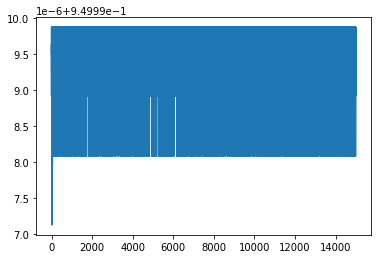

In [41]:
plt.plot(range(len(iter_losses)), iter_losses)

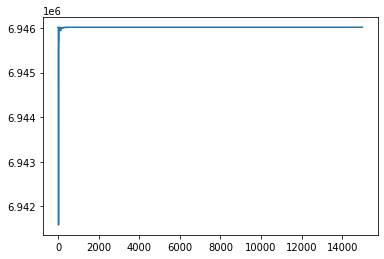

In [42]:
plt.plot(range(len(mask_sums)), mask_sums)

In [43]:
from mpl_toolkits import mplot3d

In [64]:
def draw_mask(mask):
#     mask = mask[0][0]
    mask = mask[0][0][0]
    mask_shape = mask.shape
    x, y, z, c = [], [], [], []
    
    for i in range(mask_shape[0]):
        for j in range(mask_shape[1]):
            for k in range(mask_shape[2]):
                val = mask[i][j][k]
                if val > 0:
                    x.append(i)
                    y.append(j)
                    z.append(k)
                    c.append(val)
    
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection='3d')
    ax.scatter3D(x, y, z)
    plt.show()

In [57]:
X_mask.max()

7.208716e-05

In [58]:
def thres_mask(heatmap):
#     thres = heatmap.mean() * 200
    thres = 1e-5
    print(thres)
    ones = np.ones(heatmap.shape)
    mask = ones * [heatmap > thres]
    return mask

In [59]:
t_mask = thres_mask(X_mask)

1e-05


In [60]:
np.count_nonzero(t_mask) / (192*192*192)

0.000610492847583912

In [61]:
t_mask.sum() / (192*192*192)

0.000610492847583912

In [62]:
np.allclose(t_mask, X_mask)

False

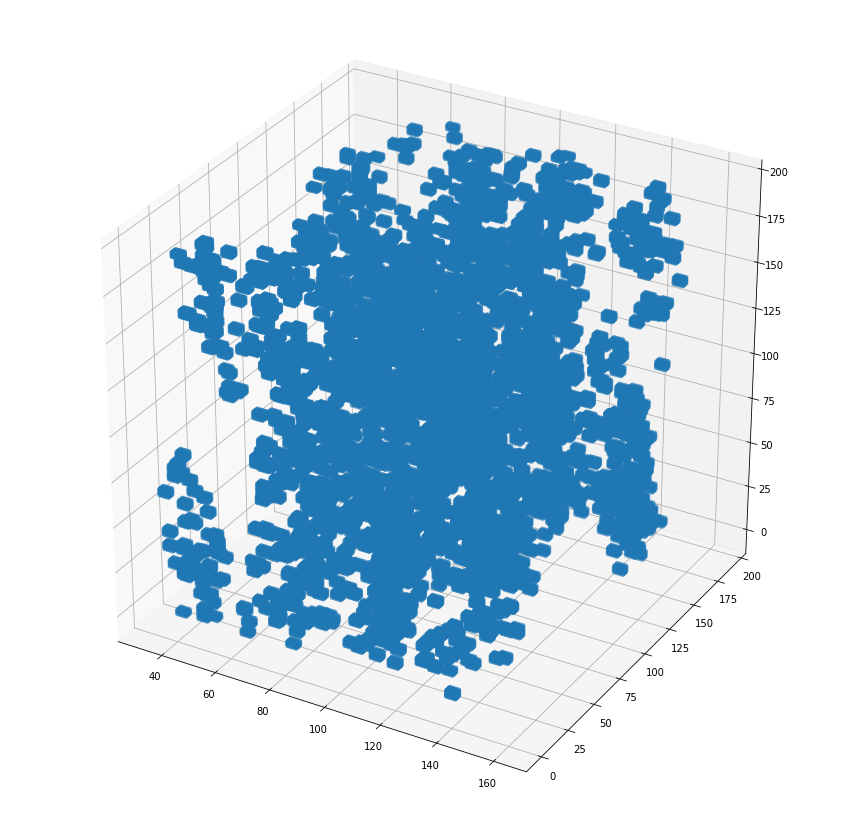

In [54]:
draw_mask(X_mask)

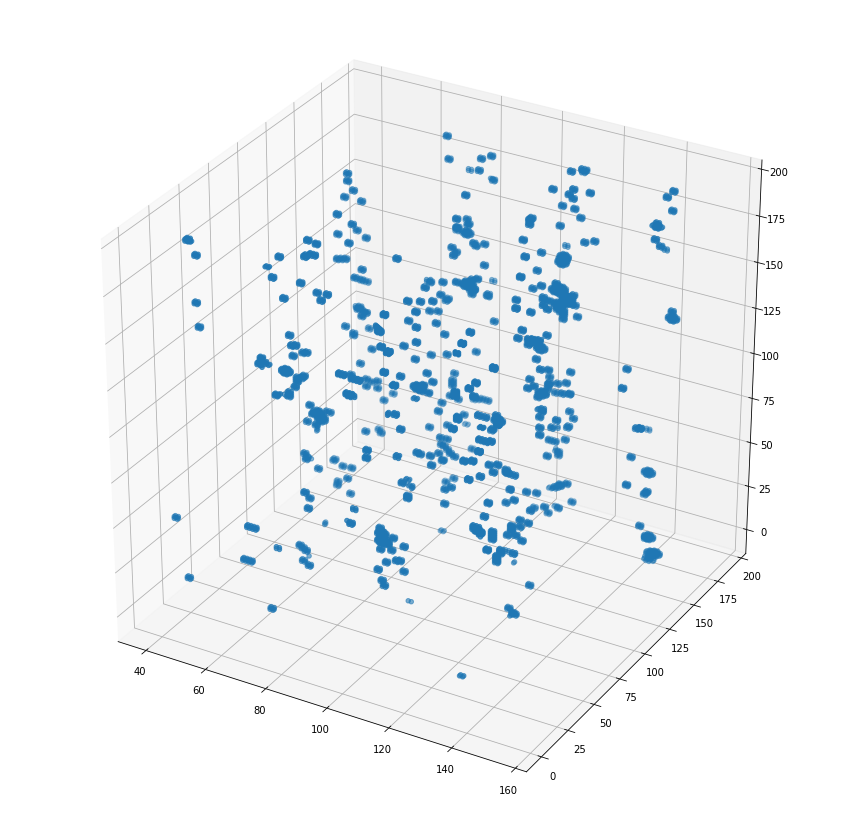

In [65]:
draw_mask(t_mask)

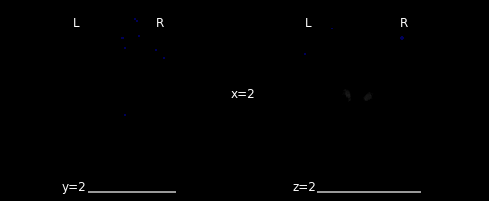

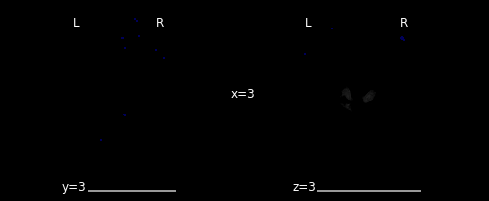

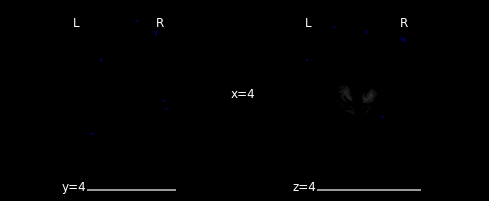

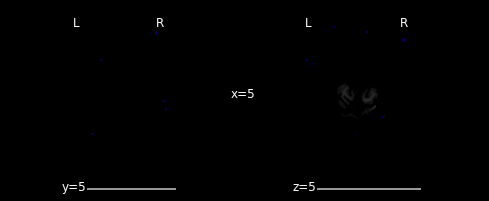

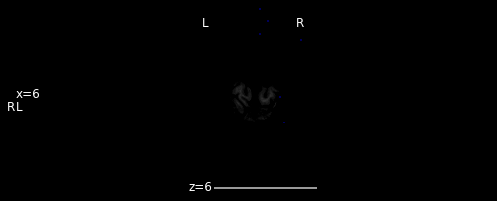

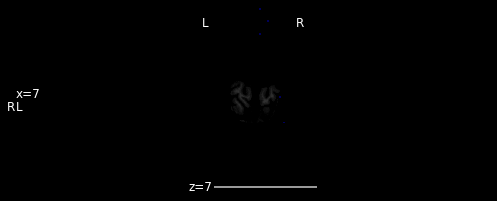

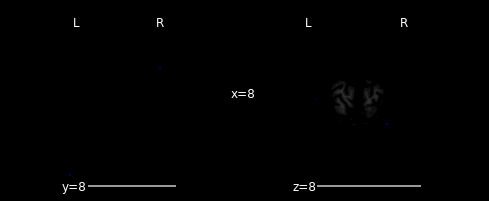

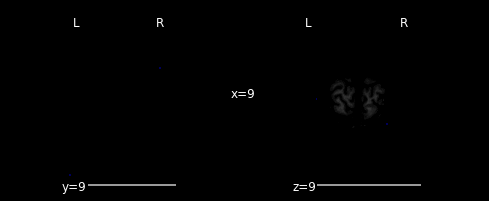

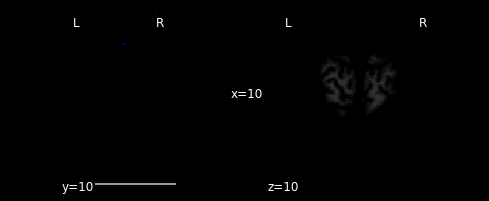

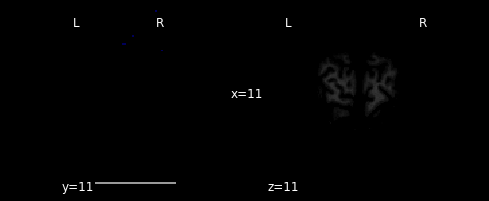

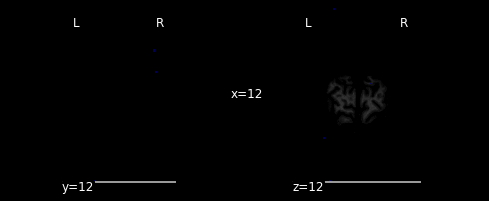

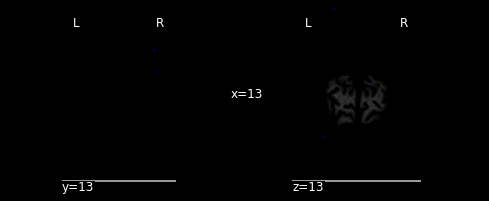

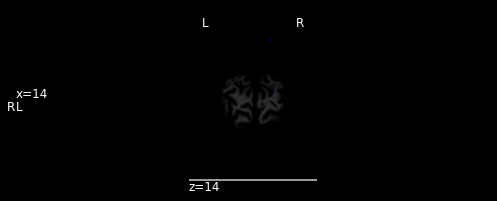

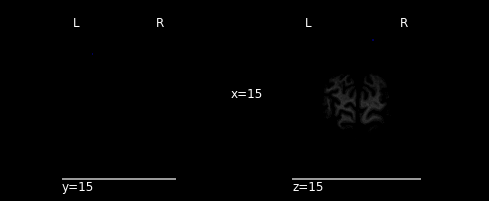

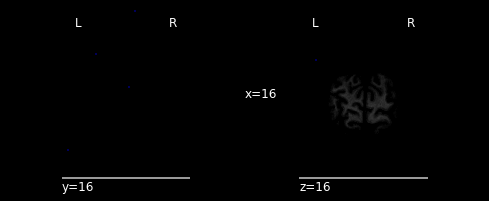

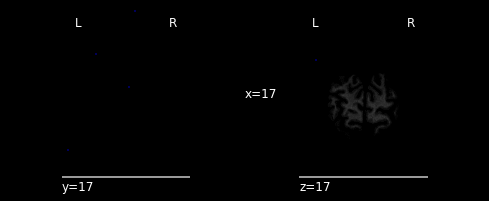

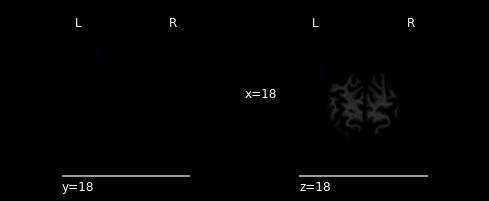

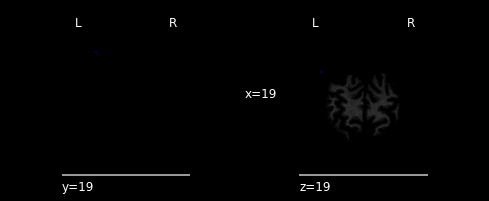

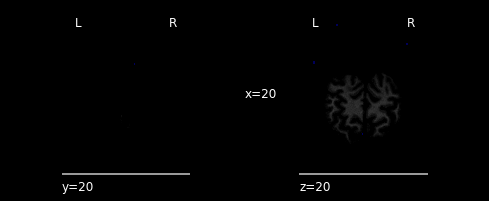

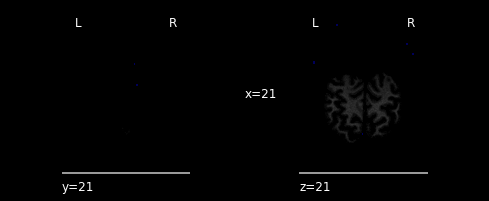

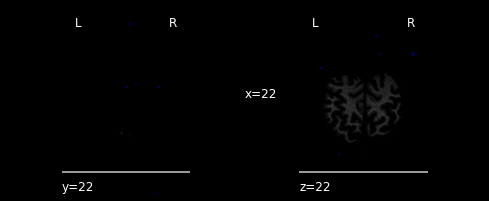

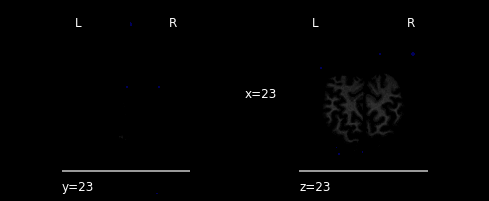

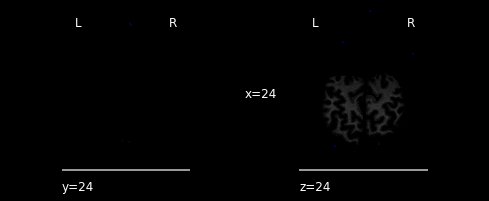

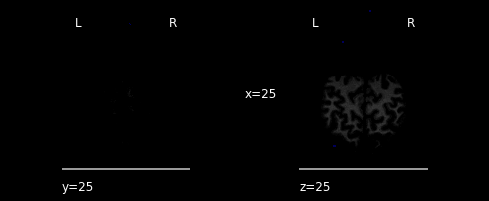

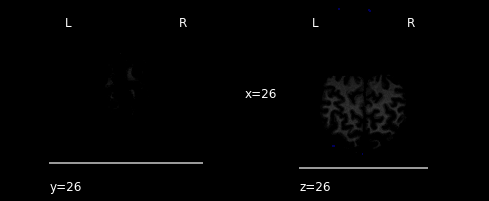

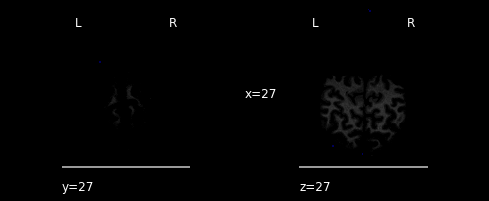

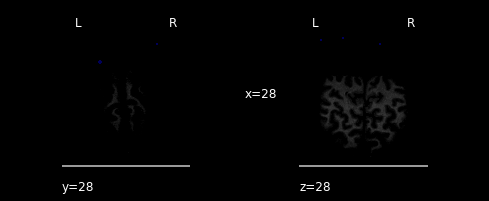

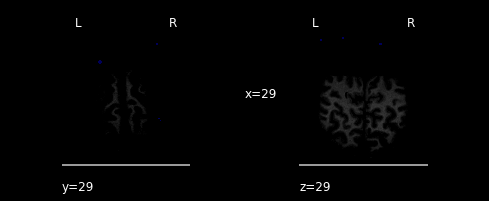

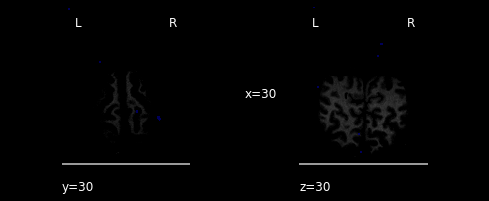

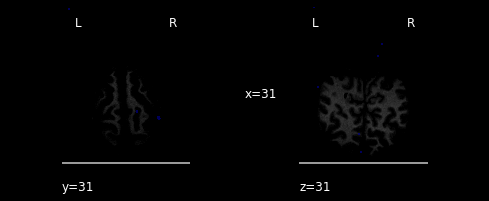

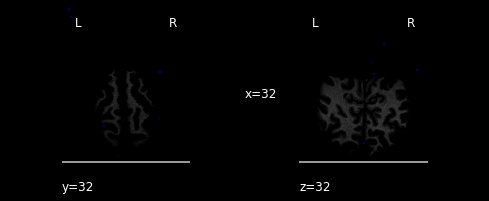

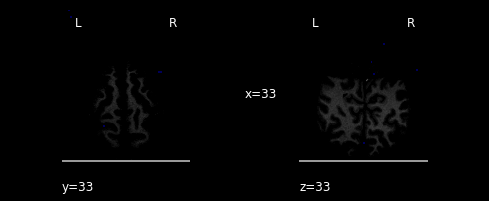

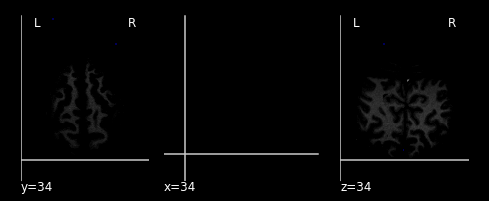

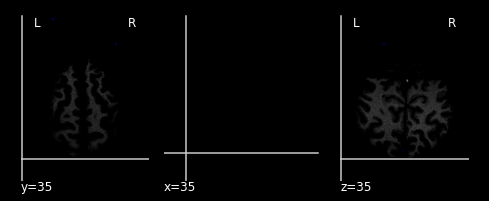

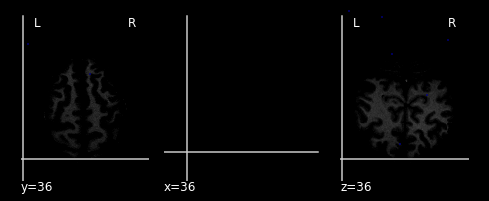

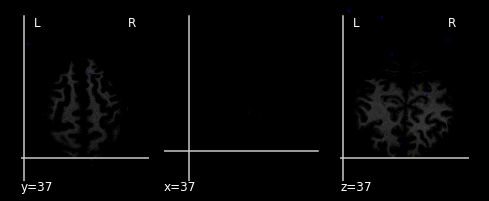

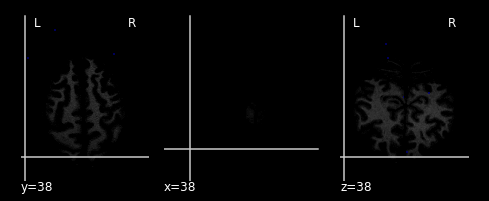

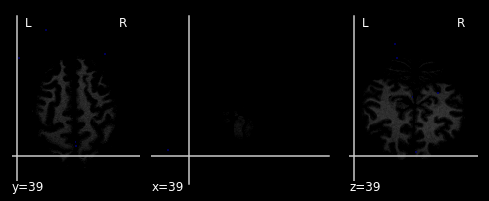

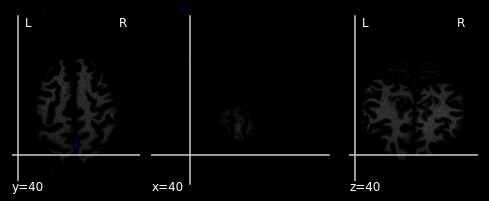

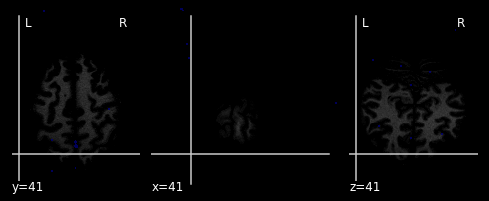

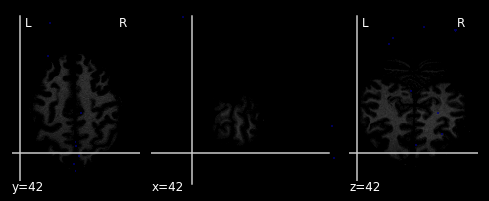

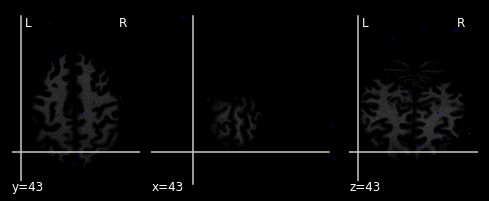

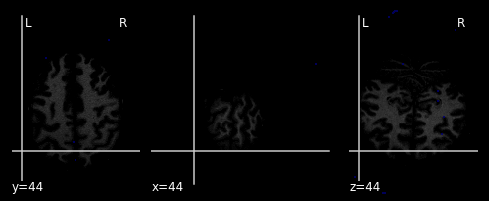

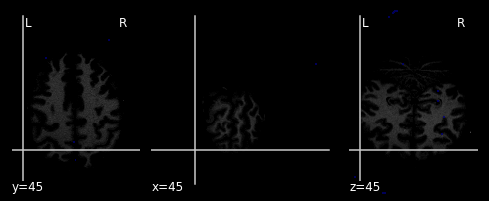

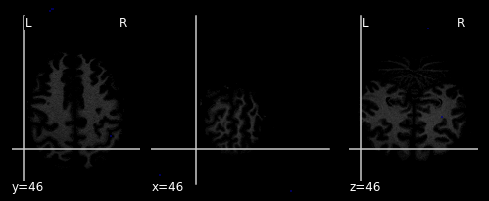

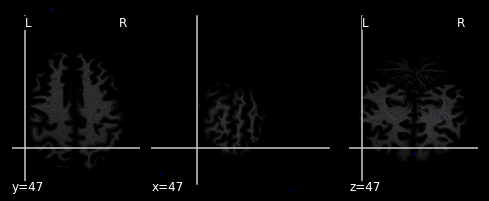

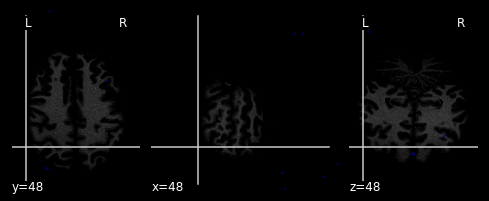

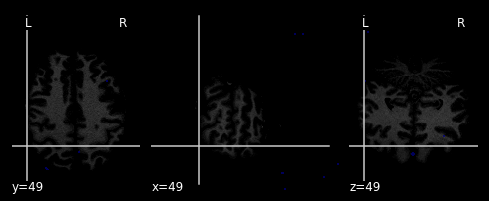

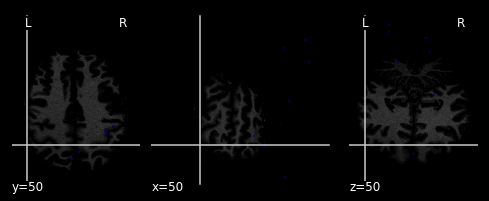

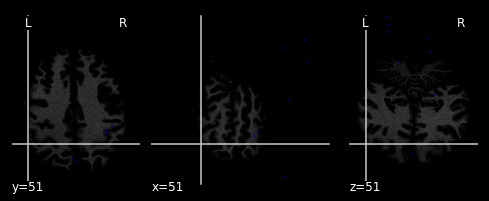

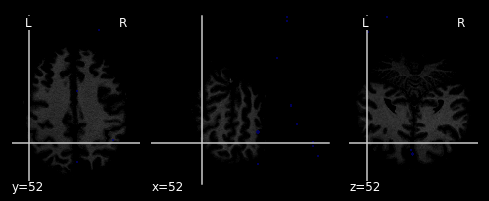

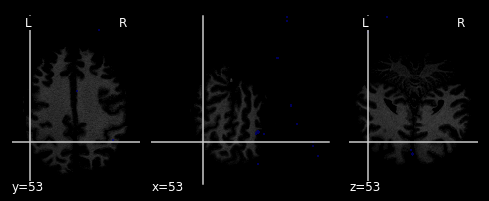

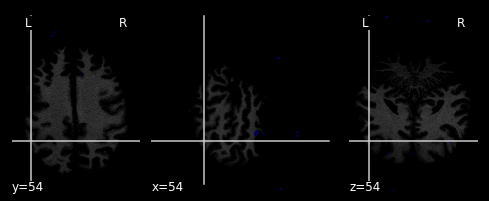

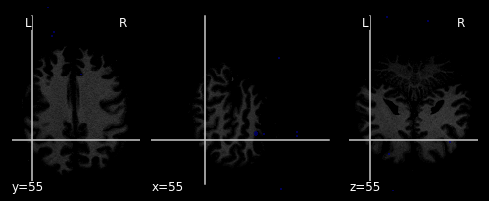

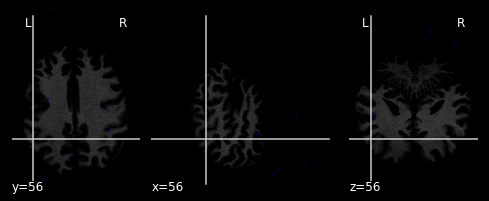

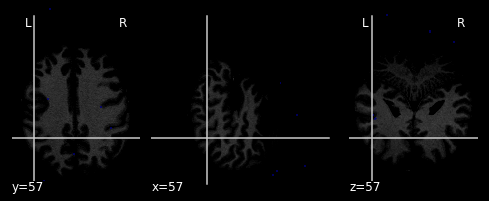

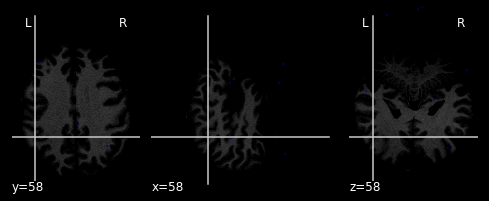

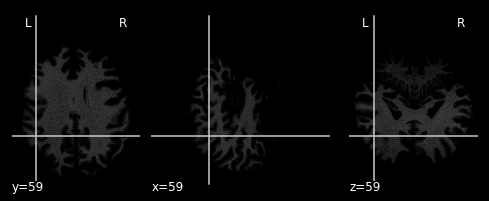

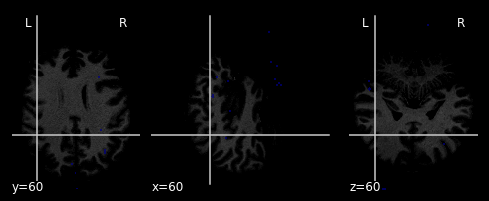

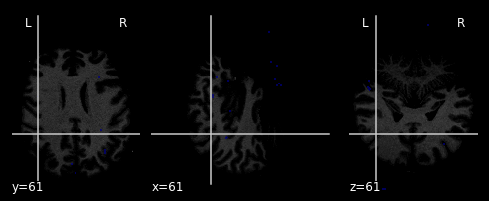

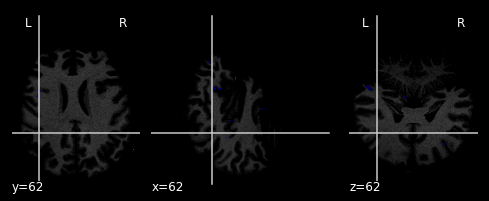

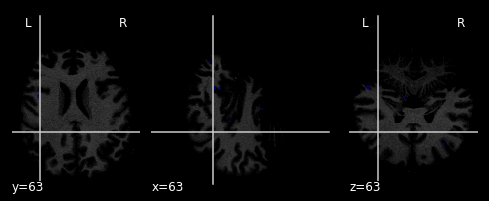

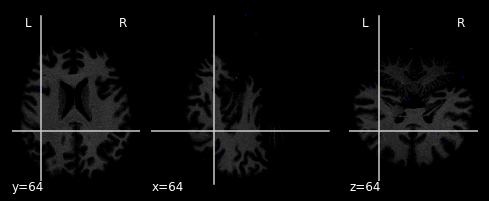

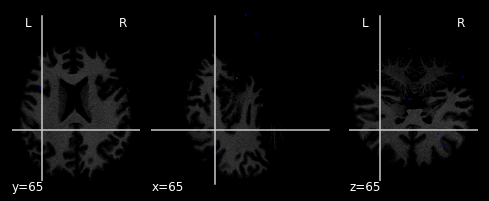

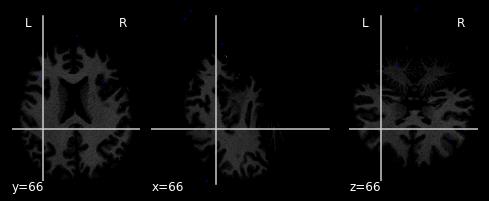

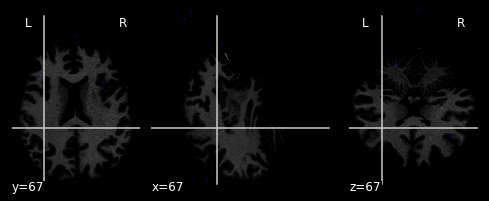

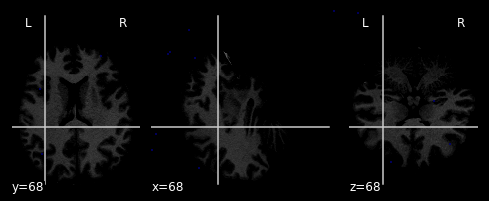

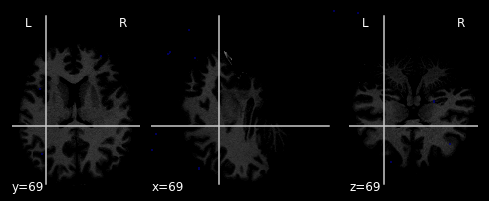

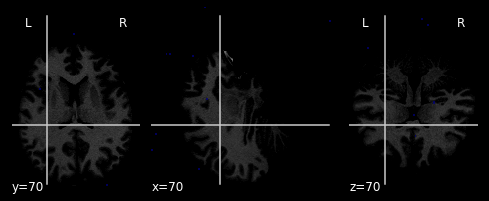

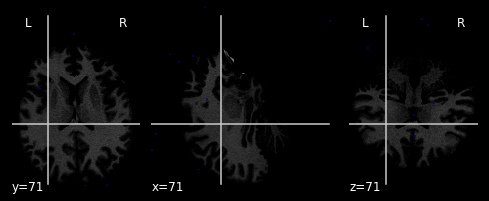

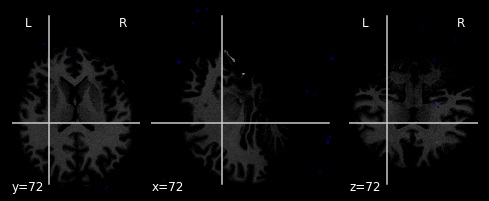

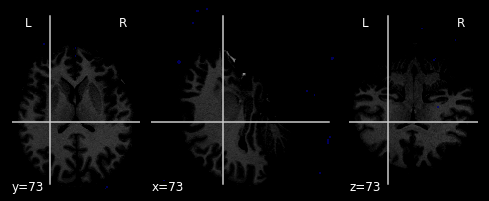

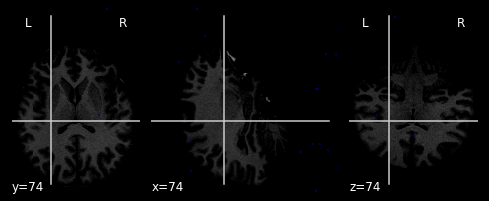

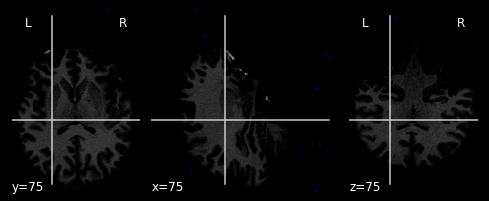

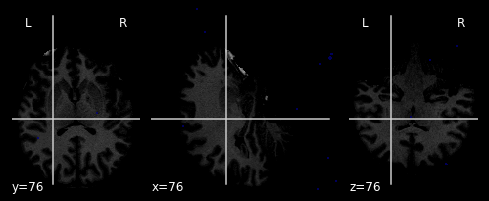

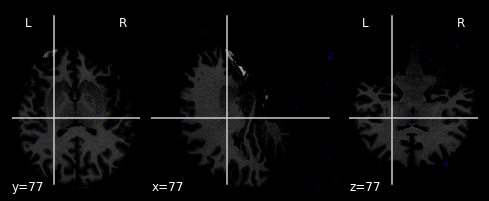

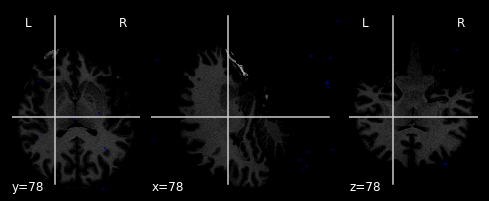

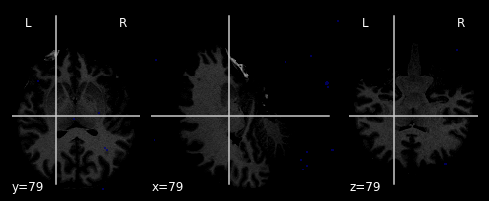

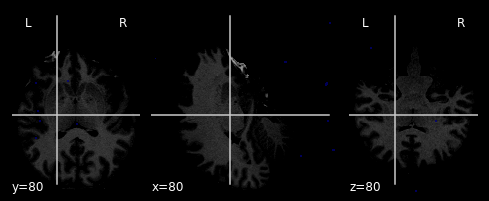

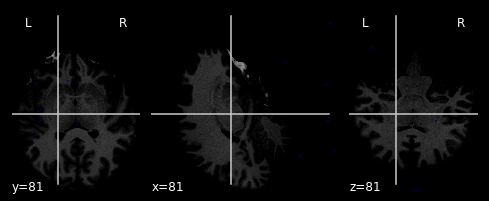

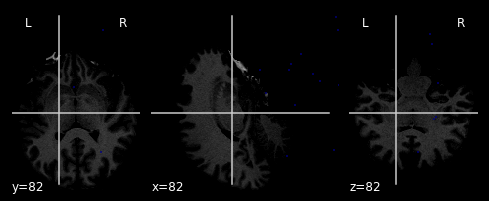

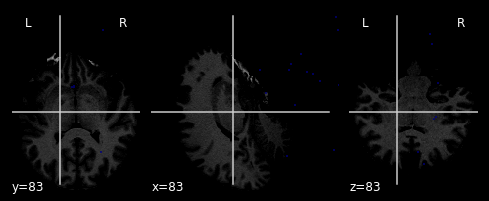

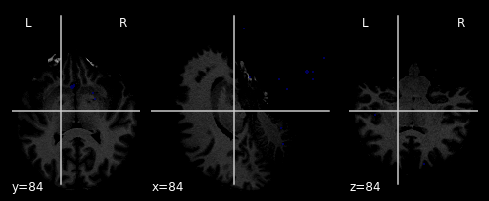

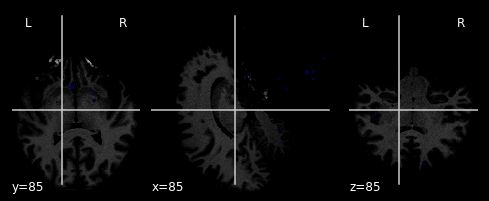

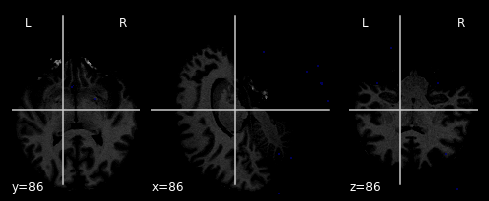

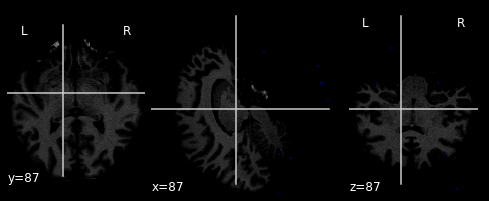

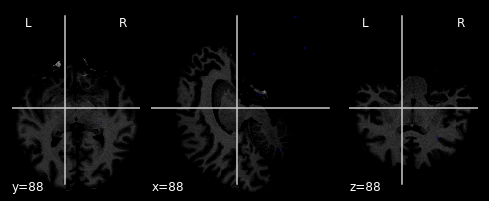

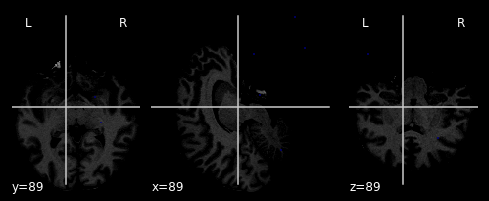

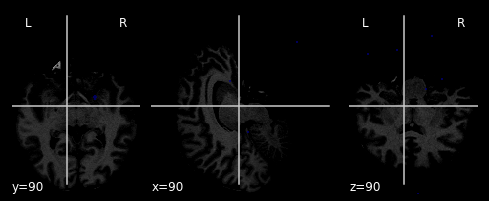

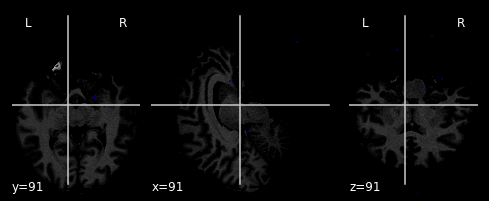

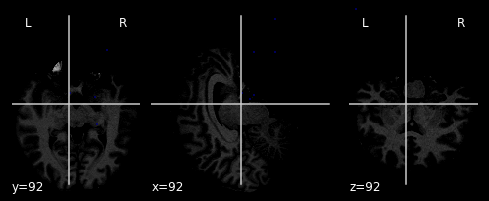

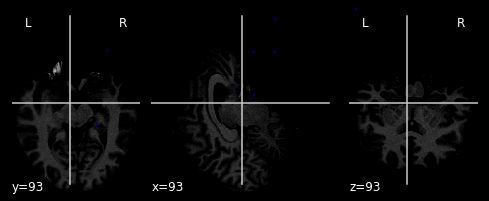

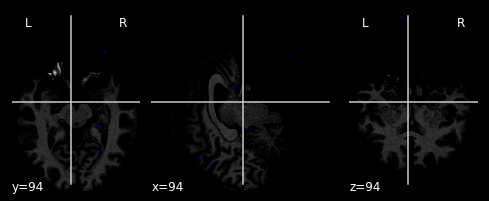

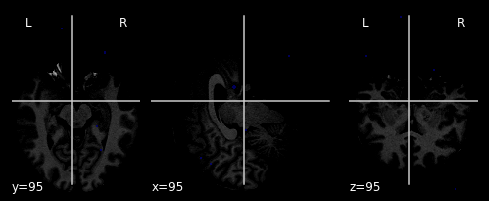

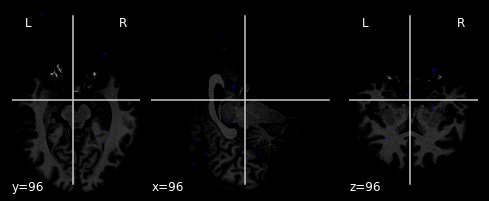

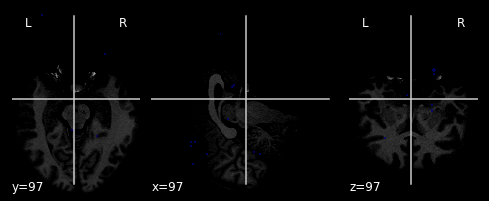

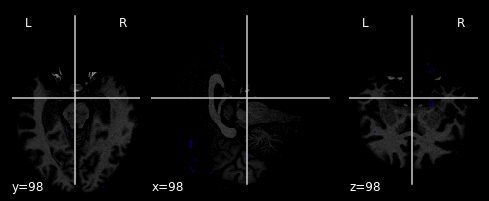

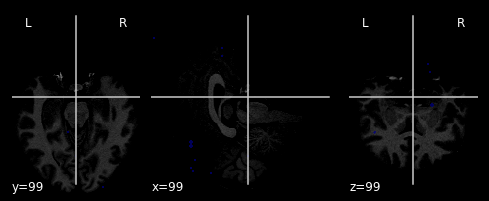

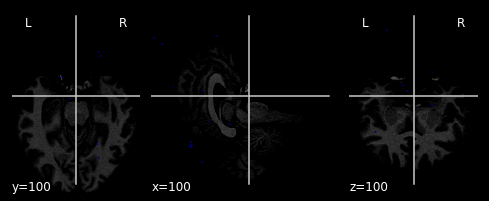

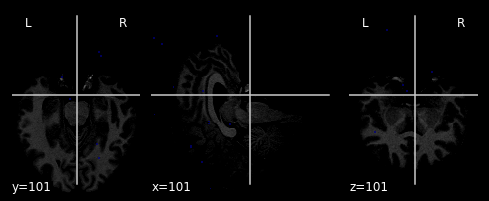

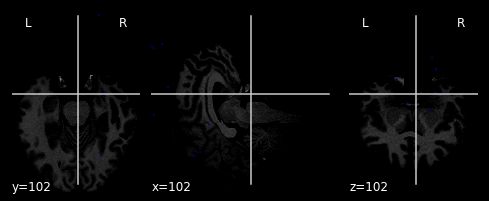

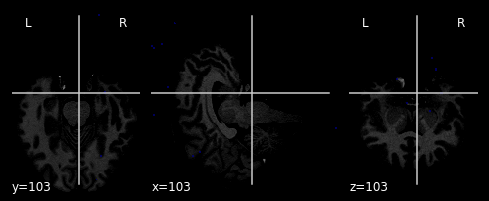

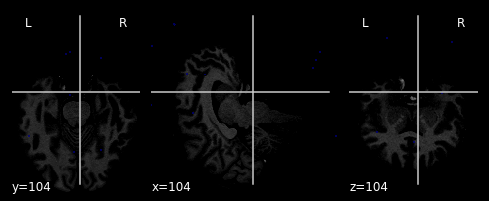

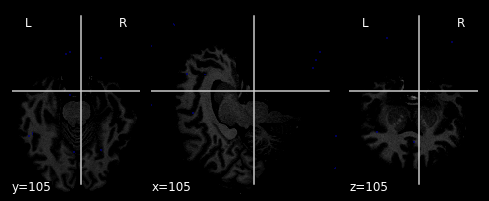

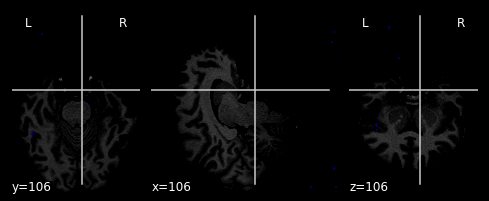

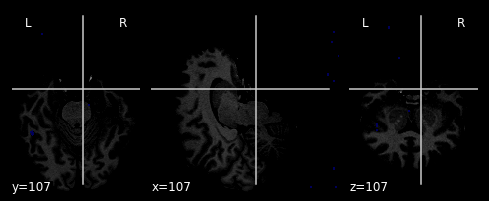

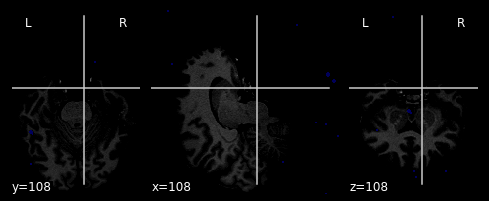

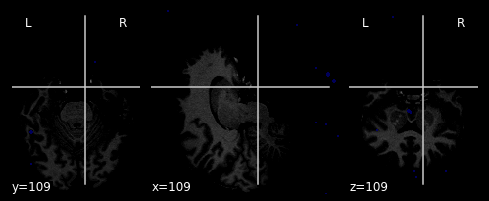

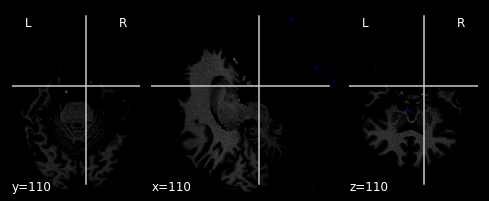

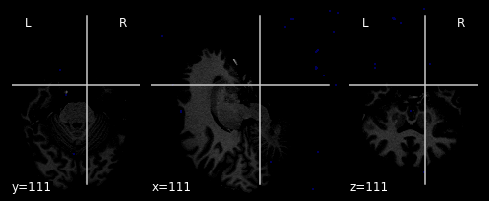

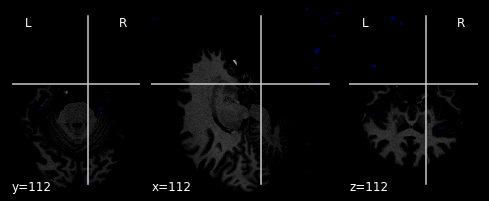

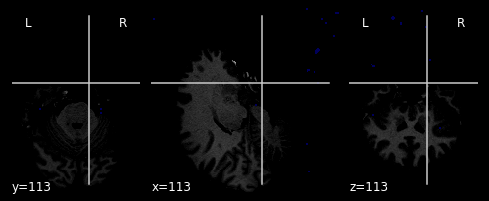

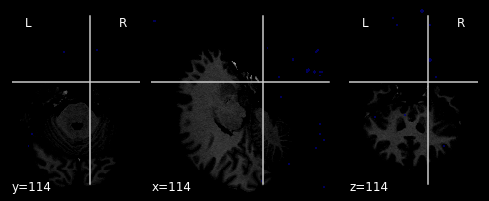

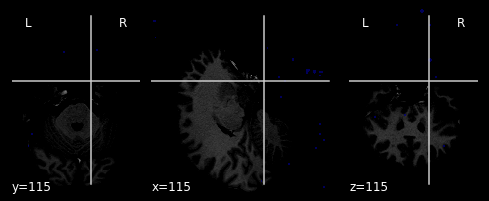

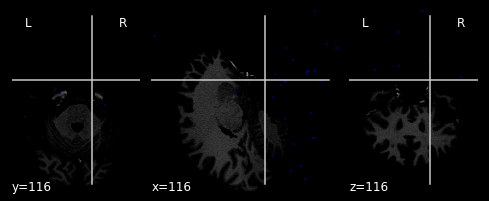

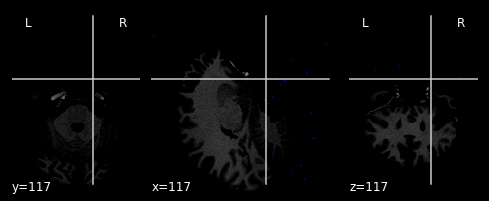

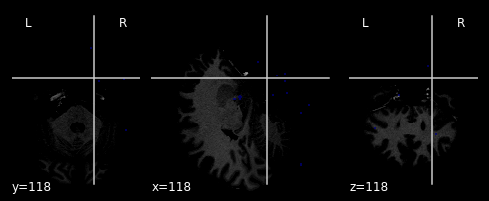

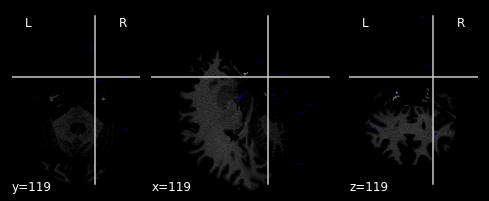

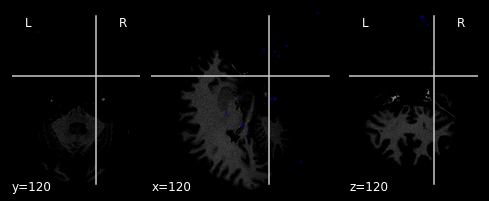

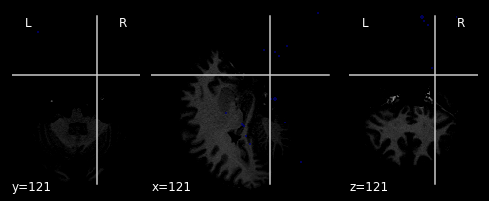

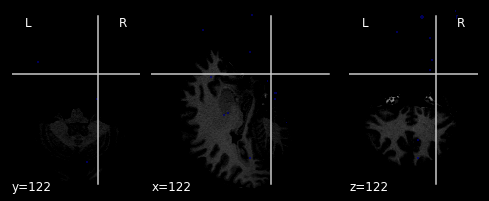

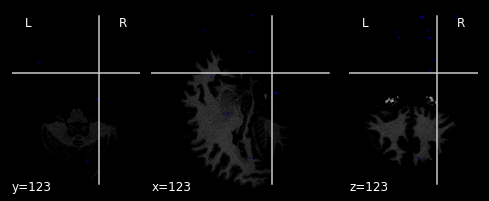

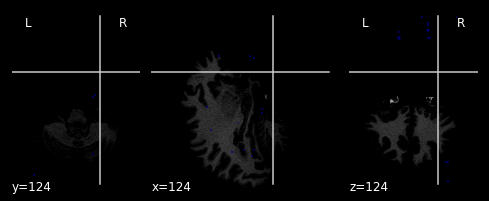

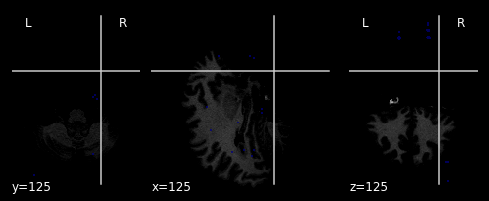

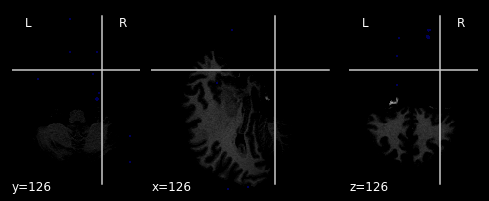

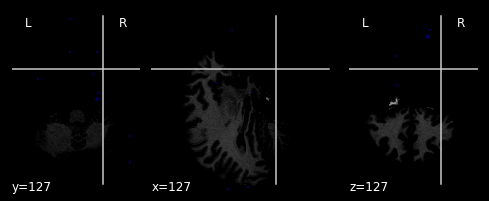

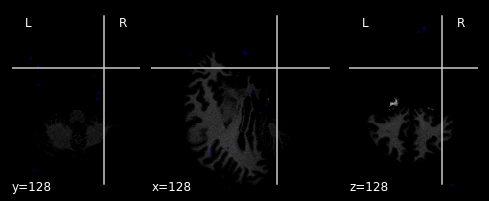

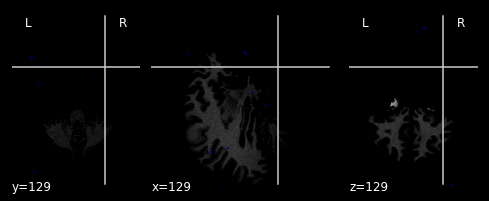

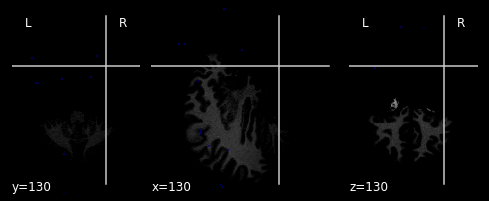

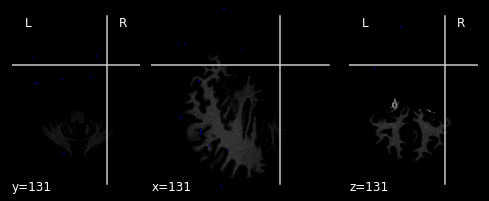

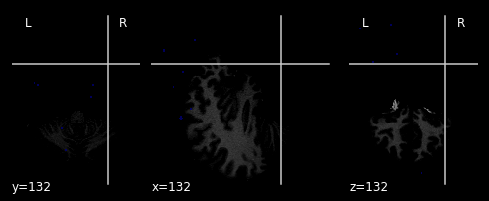

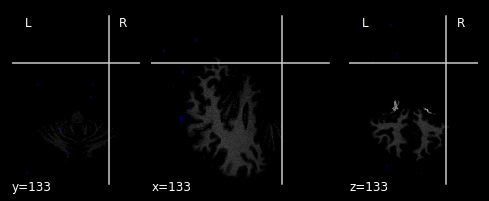

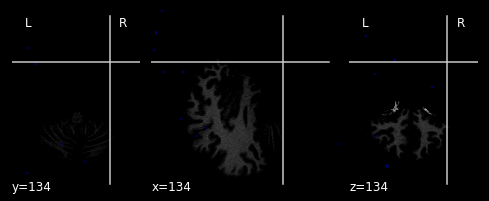

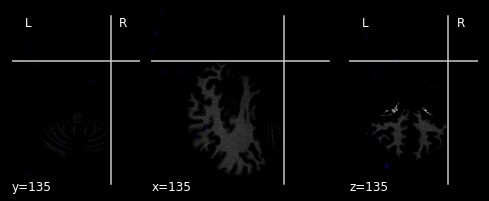

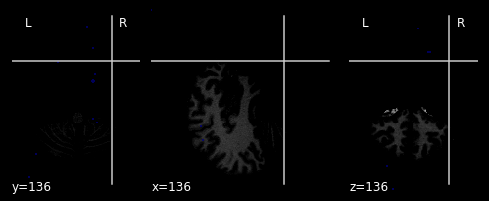

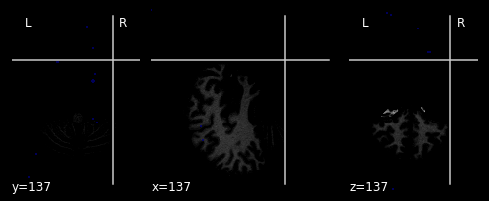

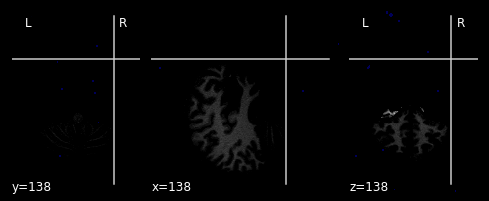

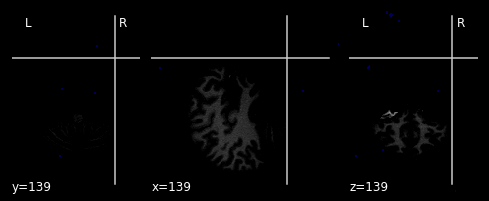

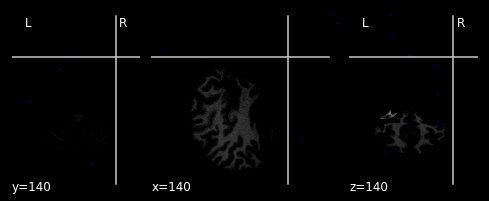

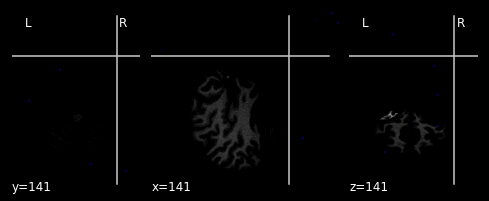

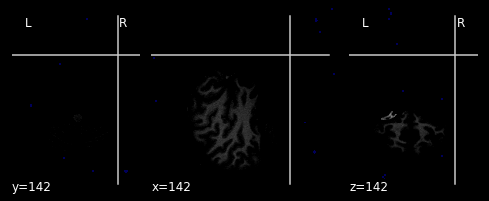

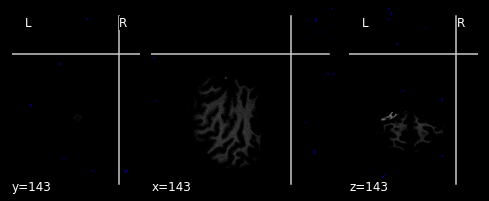

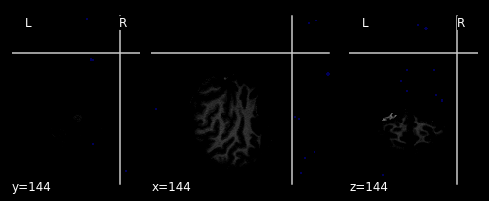

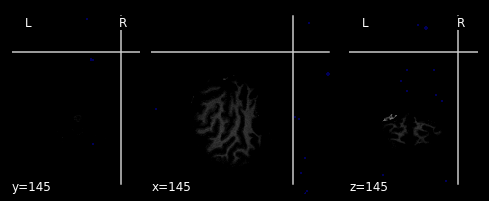

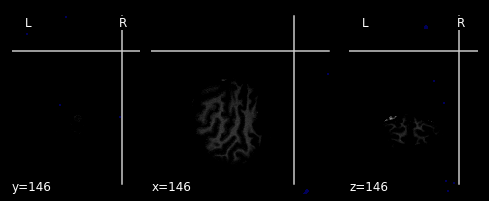

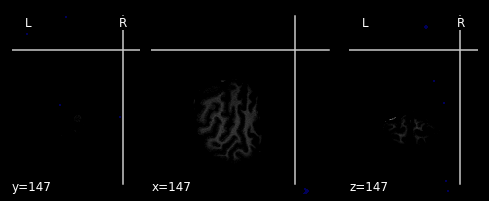

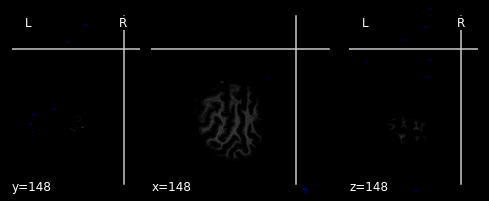

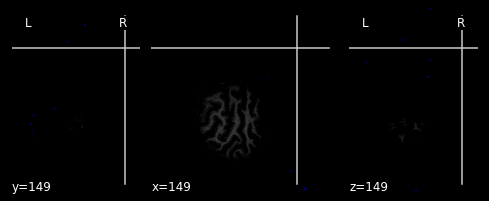

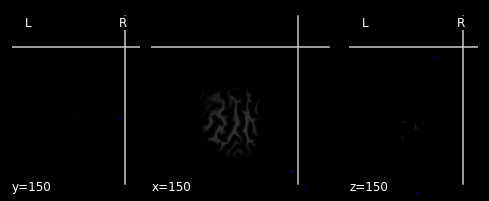

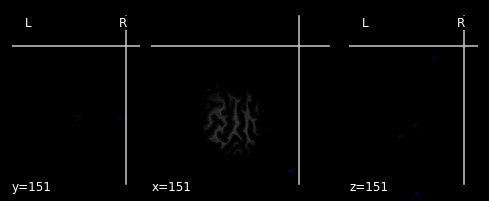

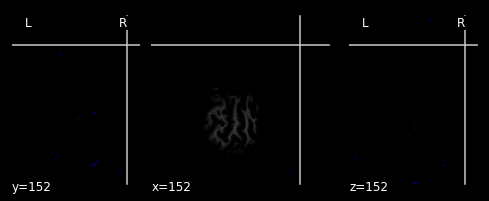

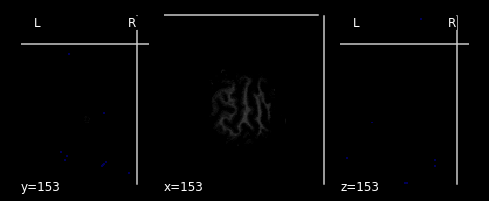

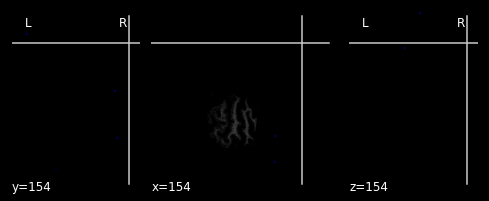

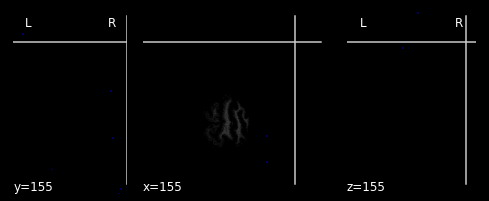

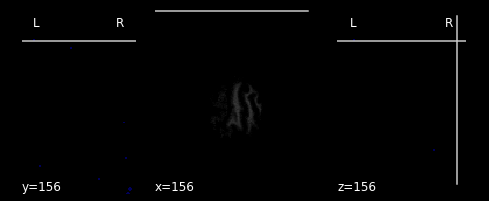

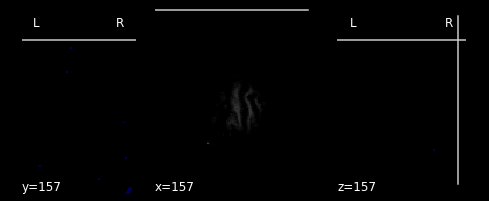

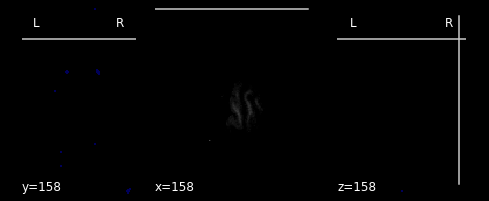

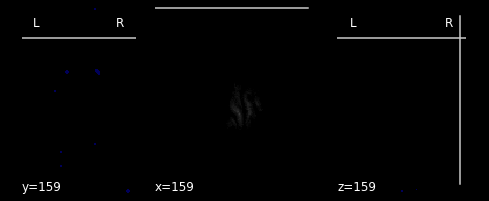

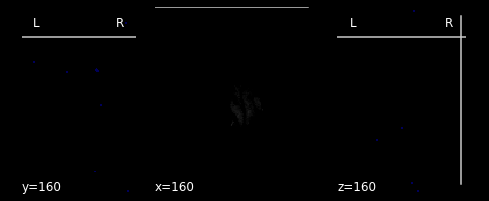

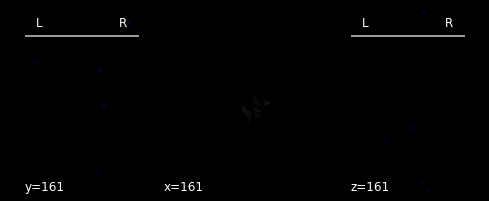

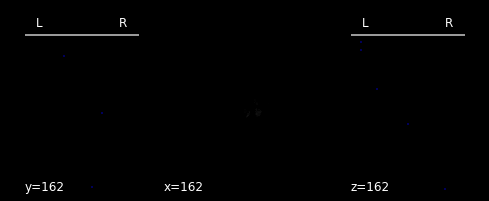

In [66]:
# roi_img = nib.Nifti1Image( np.squeeze(X_mask[1]),affine=np.eye(4))
# bim_img  = nib.Nifti1Image(np.squeeze(sample_X[1].detach().cpu().numpy()),affine=np.eye(4))
roi_img = nib.Nifti1Image( np.squeeze(t_mask),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(sample_X.detach().cpu().numpy()),affine=np.eye(4))
for i in range(2, 163):
    plotting.plot_roi(roi_img,bim_img,cut_coords=(i,i,i))
    plotting.show()